## Image Color Normalization

This notebook implements part of the image color normalization process described in appendix 3 of the paper ["Detecting Cancer Metastases on Gigapixel Pathology Images"](https://arxiv.org/abs/1703.02442).

The code obviously needs to be refactored into a class, but since I wasn't able to finish the implementation, there was no point in doing that.

In [240]:
import numpy as np
import h5py
from scipy.optimize import curve_fit
from scipy.linalg import sqrtm
from matplotlib import pyplot as plt
%matplotlib inline

Load the dataset and visualize a few samples:

In [2]:
hdf5_images_path = '../../Downloads/camelyonpatch_level_2_split_train_x.h5'
hdf5_images_file = h5py.File(hdf5_images_path, 'r')
images = hdf5_images_file['x']

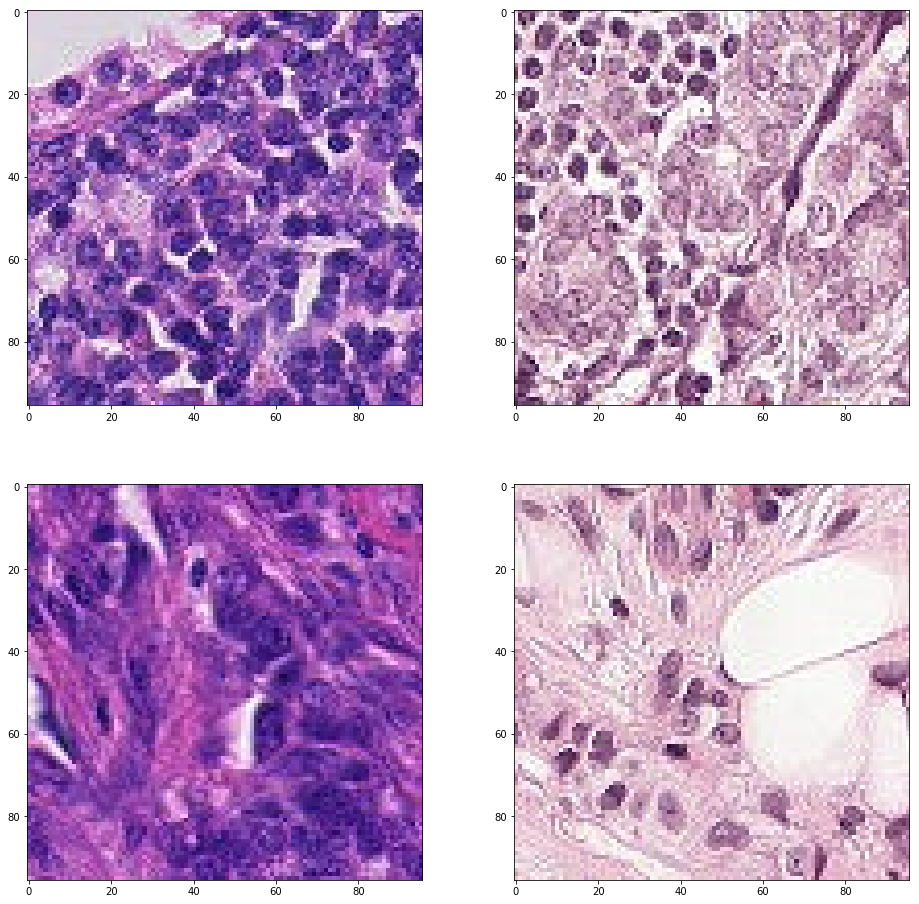

In [4]:
i = 0
m = 2
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
cells[0,0].imshow(images[i])
cells[0,1].imshow(images[i+1])
cells[1,0].imshow(images[i+2])
cells[1,1].imshow(images[i+3])

Step 1: Convert images from RGB to HSI (hue, saturation, intensity).

In [5]:
def convert_to_hsi(image):
    '''
    Converts images from the RGB to the HSI color space.
    '''
    
    r = image[:,:,0].astype(np.float)
    g = image[:,:,1].astype(np.float)
    b = image[:,:,2].astype(np.float)
    
    d_r = -np.log((r+1)/257)
    d_g = -np.log((g+1)/257)
    d_b = -np.log((b+1)/257)
    
    d   = (d_r + d_g + d_b) / 3
    c_x = d_r / d - 1
    c_y = (d_g - d_b) / (np.sqrt(3) * d)
    
    return np.stack((c_x, c_y, d), axis=-1)

Step 2: Compile a vector of HSI channel values over the dataset.

In [147]:
def compile_hsi_feature_vectors(hdf5_images_path, dataset='x', start=0, end=1000):
    '''
    Returns two vectors ((c_x, c_y)_i and (d)_i) with the values of the HSI color channels
    over a portion of the dataset.
    '''

    hdf5_images_file = h5py.File(hdf5_images_path, 'r')
    images = hdf5_images_file[dataset]
    
    if end is None:
        end = len(images)

    cxcy = []
    d = []

    for i in range(start, end):
        image_hsi = convert_to_hsi(images[i])
        cxcy.append(np.reshape(image_hsi[:,:,:2], (-1,2)))
        d.append(np.reshape(image_hsi[:,:,2], (-1,)))
    cxcy = np.concatenate(cxcy, axis=0)
    d = np.concatenate(d, axis=0)

    return cxcy, d

In [148]:
cxcy, d = compile_hsi_feature_vectors(hdf5_images_path='../../Downloads/camelyonpatch_level_2_split_train_x.h5',
                                      dataset='x',
                                      start=0,
                                      end=1000)

Plot the (c_x, c_y) plane to get an idea of the underlying distribution.

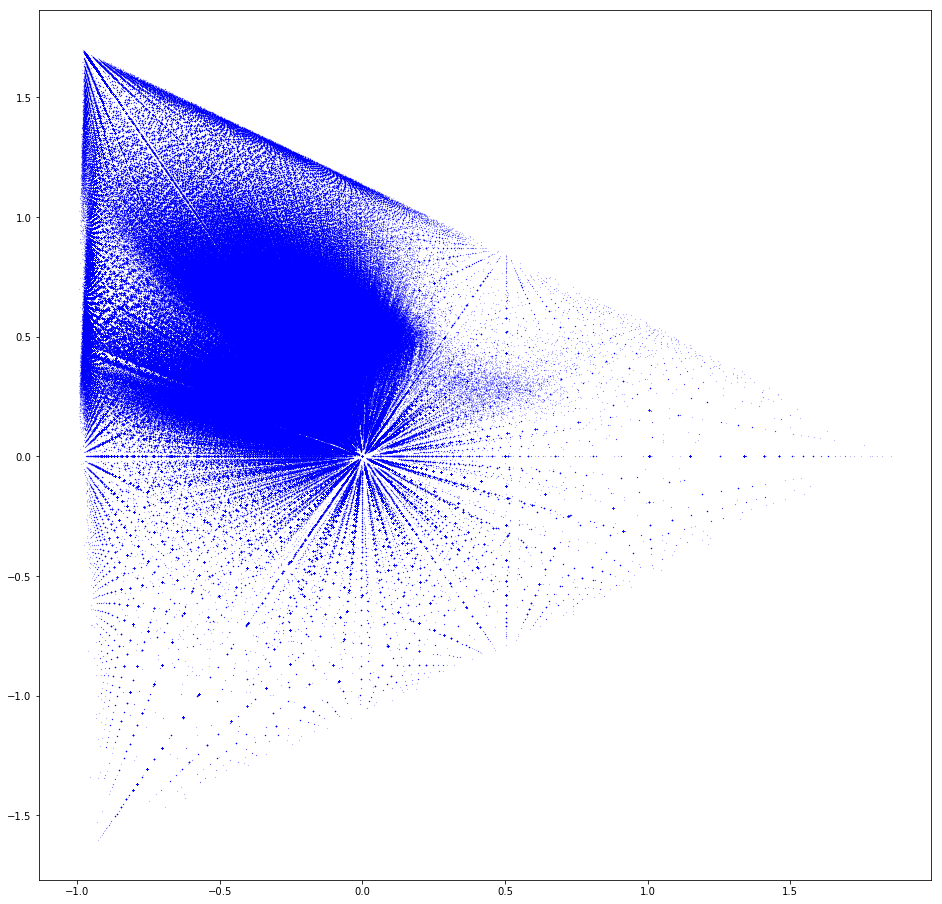

In [146]:
plt.figure(figsize = (16,16))
plt.plot(cxcy[:,0], cxcy[:,1], 'bo', ms=0.1)

In [209]:
def histogram_2d(points, bins=200, normed=True):
    '''
    Returns the bin center points and corresponding histogram counts of a set of 2D points.
    This is just a wrapper for `numpy.histogram2d()` that returns bin center points rather
    than bin edges and reshapes the data into 1D vectors.
    '''
    
    H, yedges, xedges = np.histogram2d(x=points[:,1], y=points[:,0], bins=bins, normed=True)
    
    # Compute the bin center points.
    x_centroids = (xedges + (xedges[1] - xedges[0]))[:-1]
    y_centroids = (yedges + (yedges[1] - yedges[0]))[:-1]
    
    # Reshape into 1D vectors.
    vec = np.reshape(np.stack(np.meshgrid(x_centroids, y_centroids), axis=-1), (-1, 2))
    values = np.reshape(H, (-1,))
    
    return vec, values

In [210]:
def histogram_1d(x, bins=200, normed=True):
    '''
    Same as `histogram_2d()` but for the 1D case.
    '''
    
    hist, bin_edges = np.histogram(x, bins=bins, density=normed)
    
    # Compute the bin center points.
    bin_centroids = (bin_edges + (bin_edges[1] - bin_edges[0]))[:-1]
    
    return hist, bin_centroids

Plot a histogram of the density channel.

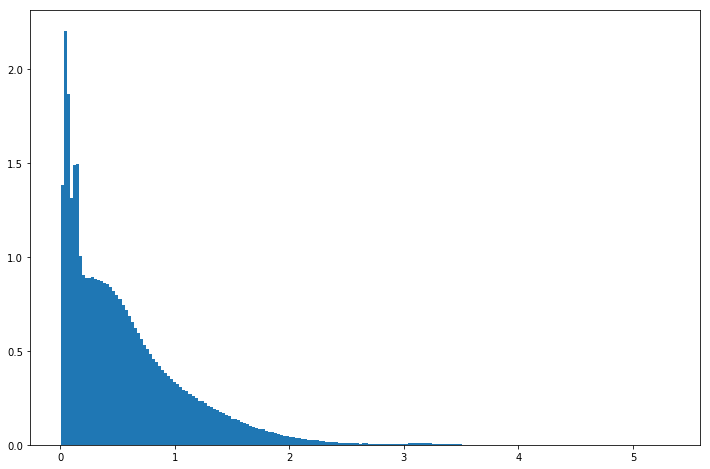

In [204]:
#hist, binedges = np.histogram(d, bins=200)
plt.figure(figsize = (12,8))
hist, binedges, patches = plt.hist(d, bins=200, normed=True)

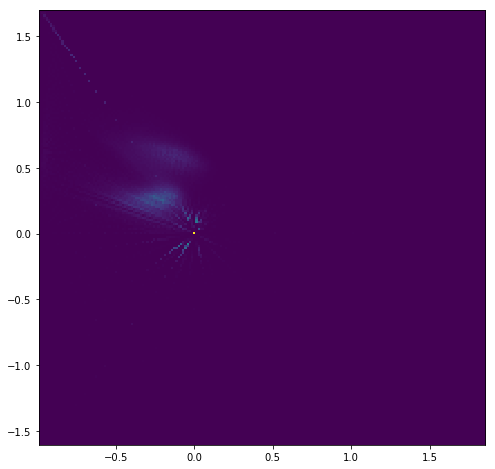

In [199]:
plt.figure(figsize = (8,8))
H, xedges, yedges, axes_image = plt.hist2d(x=cxcy[:,0], y=cxcy[:,1], bins=200, normed=True)

In [223]:
def gaussian_density_2d(vec, mu_x, mu_y, sigma_x, sigma_y, sigma_xy):
    
    x, y     = vec
    rho      = sigma_xy / (sigma_x * sigma_y) # Correlation coefficient
    C        = 1 / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - rho**2)) # Scaling constant
    x_std    = (x - mu_x) / sigma_x # Standardized x
    y_std    = (y - mu_y) / sigma_y # Standardized y
    gaussian = np.exp(-1 / (2 * (1 - rho**2)) * (x_std**2 + y_std**2 - 2 * rho * x_std * y_std)) # Unscaled Gaussian function
    return C * gaussian # Scaled Gaussian function

def gaussian_density_1d(x, mu, sigma):
    
    C        = 1 / (sigma * np.sqrt(2 * np.pi)) # Scaling constant
    x_std    = (x - mu) / sigma # Standardized x
    gaussian = np.exp(-1/2 * x_std**2) # Unscaled Gaussian function
    return C * gaussian # Scaled Gaussian function

In [233]:
def fit_gaussian_2d(points, bins=200, p0=None):
    '''
    Fits a 2D gaussian density function to a set of 2D points
    and returns the mean vector and covariance matrix.
    '''
    
    vec, values = histogram_2d(points=points, bins=bins, normed=True)

    popt, pcov = curve_fit(f=gaussian_density_2d,
                           xdata=(vec[:,0],vec[:,1]),
                           ydata=values,
                           p0=p0,
                           bounds=([-np.inf, -np.inf, 0.001, 0.001, -np.inf],
                                   [np.inf, np.inf, np.inf, np.inf, np.inf]))
    
    mu    = np.array([[popt[0]], [popt[1]]])
    sigma = np.array([[popt[2]**2, popt[4]], [popt[4], popt[3]**2]])
    
    return mu, sigma

def fit_gaussian_1d(x, bins=200, p0=None):
    '''
    Same as `fit_gaussian_2d()`, but for the 1D case.
    '''
    
    hist, bin_centroids = histogram_1d(x=x, bins=bins, normed=True)

    popt, pcov = curve_fit(f=gaussian_density_1d,
                           xdata=bin_centroids,
                           ydata=hist,
                           p0=p0,
                           bounds=([-np.inf, 0.001], [np.inf, np.inf]))
    
    mu  = popt[0]
    var = popt[1]**2
    
    return mu, var

In [234]:
mu_cxcy, sigma_cxcy = fit_gaussian_2d(points=cxcy, bins=200, p0=(-0.25, 0.25, 0.2, 0.2, 0))

mu_d, var_d = fit_gaussian_1d(x=d, bins=200, p0=(0.3, 0.3))

print("mu_cxcy:")
print(mu_cxcy)
print("sigma_cxcy:")
print(sigma_cxcy)
print()
print("[mu_d, var_d]:")
print(mu_d, var_d)

mu_cxcy:
[[-0.22938269]
 [ 0.30940757]]
sigma_cxcy:
[[ 0.0276325  -0.00250663]
 [-0.00250663  0.04898879]]

[mu_d, var_d]:
0.21194804033708756 0.13341948720932434


Compute the statistical moments.

In [237]:
def compute_moments_2d(points):
    
    mu    = np.mean(points, axis=0)
    sigma = np.cov(points, rowvar=False)
    
    return mu, sigma

def compute_moments_1d(x):
    
    mu  = np.mean(x)
    var = np.var(x)
    
    return mu, var

In [239]:
mu_cxcy_stat, sigma_cxcy_stat = compute_moments_2d(cxcy)

mu_d_stat, var_d_stat = compute_moments_1d(d)

print("mu_cxcy_stat:")
print(mu_cxcy_stat)
print("sigma_cxcy_stat:")
print(sigma_cxcy_stat)
print()
print("[mu_d_stat, var_d_stat]:", mu_d_stat, var_d_stat)

mu_cxcy_stat:
[-0.28209481  0.37306939]
sigma_cxcy_stat:
[[ 0.0511795  -0.02839332]
 [-0.02839332  0.0924293 ]]

[mu_d_stat, var_d_stat]: 0.5691206245268953 0.2712900226746665


In [246]:
def compute_monge_kantorovitch_operator(sigma, sigma_ref):
    
    sigma_sqrt     = sqrtm(sigma)
    sigma_sqrt_inv = np.linalg.inv(sigma_sqrt)
    
    T1 = np.matmul(np.matmul(sigma_sqrt, sigma_ref), sigma_sqrt)
    T1_sqrt = sqrtm(T1)
    T  = np.matmul(np.matmul(sigma_sqrt_inv, T1_sqrt), sigma_sqrt_inv)
    
    return T

In [247]:
T = compute_monge_kantorovitch_operator(sigma=sigma_cxcy, sigma_ref=sigma_cxcy_stat)

print("Monge-Kantorovitch Operator:\n")
print(T)

Monge-Kantorovitch Operator:

[[ 1.30401125 -0.233313  ]
 [-0.233313    1.35047968]]


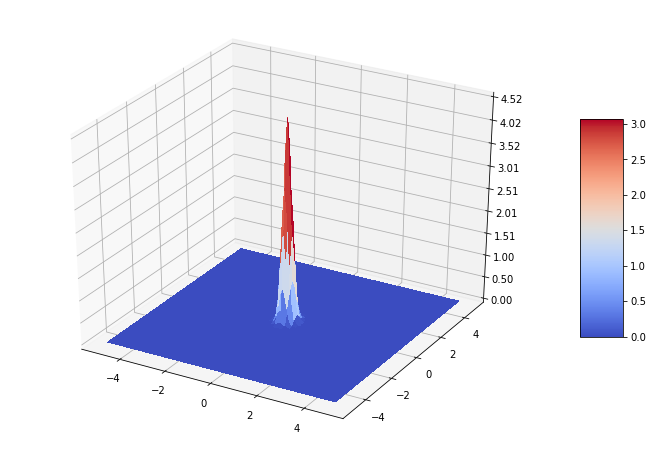

In [222]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')

# Make some data.
X = np.arange(-5, 5, 0.1)
Y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = gaussian_density_2d((X,Y), mu_x=0, mu_y=0, sigma_x=0.16, sigma_y=0.22, rho=0)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()